In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Search recall

In [3]:
df = pd.read_csv('../data/results/eval.csv')

df = df[df["term"] == "max_lot_coverage"][["town", "district", "correct_answer", "expected", "expected_normalized", "expected_extended", "actual", "actual_normalized", "confidence", "correct_page_searched", "correct_page_extracted", "gt_page", "searched_pages", "searched_pages_expanded", "extracted_pages"]]

In [4]:
sdf = df.groupby(by=['town', 'district']).agg({"correct_page_searched": "max"}).reset_index()

In [5]:
recall = sdf["correct_page_searched"].sum() / sdf.shape[0]
print("page search recall =", recall)

page search recall = 0.625


In [6]:
# Display all results for which no correct page was searched.
df.merge(sdf.query("correct_page_searched == 0"), on=["town", "district"]).query("expected.isna()")

,town,district,correct_answer,expected,expected_normalized,expected_extended,actual,actual_normalized,confidence,correct_page_searched_x,correct_page_extracted,gt_page,searched_pages,searched_pages_expanded,extracted_pages,correct_page_searched_y
0,andover,Andover Lake,False,NaN,NaN,NaN,60 percent,60.0,1.0,0,0,set(),{189},"{192, 188, 189, 190, 191}",{188},0
1,andover,Andover Lake,False,NaN,NaN,NaN,10%,10.0,1.0,0,0,set(),{96},"{96, 97, 95}",{97},0
5,barkhamsted,Restricted Business,False,NaN,NaN,NaN,40 percent,40.0,1.0,0,0,set(),{21},"{20, 21}",{20},0
6,barkhamsted,General Business,False,NaN,NaN,NaN,40 percent,40.0,1.0,0,0,set(),{21},"{20, 21}",{20},0
7,bethel,Commercial,False,NaN,NaN,NaN,25 percent of gross lot area,25.0,1.0,0,0,{73},{114},"{113, 114, 115}",{114},0
8,bethel,Commercial,True,NaN,NaN,NaN,NaN,NaN,0.0,0,0,{73},{57},"{56, 57, 58, 59, 60}",set(),0
9,bethel,Commercial,True,NaN,NaN,NaN,NaN,NaN,0.0,0,0,{73},{100},"{99, 100, 101, 102, 103}",set(),0
10,bethel,Commercial,True,NaN,NaN,NaN,NaN,NaN,0.0,0,0,{73},{48},"{48, 47}",set(),0
15,brooklyn,Industrial,False,NaN,NaN,NaN,80 percent,80.0,1.0,0,0,{86},{56},"{56, 57, 55}",{57},0
16,brooklyn,Industrial,True,NaN,NaN,NaN,NaN,NaN,0.0,0,0,{86},{66},"{65, 66, 67, 68, 69, 70}",set(),0


### Answer accuracy

In [7]:
gt = pd.read_csv('../data/ground_truth.csv')

In [8]:
gt_towns = list(gt['town'].unique())

In [9]:
df = pd.read_csv('../data/results/eval.csv')
term = 'max_lot_coverage'
df = df[df['term'] == term]

In [10]:
df_towns = list(df['town'].unique())

In [11]:
adf = df.groupby(by=['town', 'district']).agg({"correct_answer": "max"}).reset_index()

In [12]:
acc = adf["correct_answer"].sum() / adf.shape[0]
print("accuracy =", acc)

accuracy = 0.5833333333333334


In [13]:
df_inc = df.merge(adf[adf["correct_answer"] == 0], on=["town", "district"])

In [14]:
len(df_inc[df_inc["correct_page_searched"] == 1])

3

In [28]:
df_wrong = df_inc.query("~correct_answer_x")
df_cond_wrong = df_wrong.query("correct_page_searched == 1")
df_search_wrong = df_wrong.query("correct_page_searched == 0")

In [29]:
df_search_wrong

,town,district,term,expected,expected_extended,actual,confidence,correct_page_searched,correct_page_extracted,gt_page,searched_pages,searched_pages_expanded,extracted_pages,actual_normalized,expected_normalized,correct_answer_x,correct_answer_y
0,andover,Andover Lake,max_lot_coverage,NaN,NaN,60 percent,1.0,0,0,set(),{189},"{192, 188, 189, 190, 191}",{188},60.0,NaN,False,False
1,andover,Andover Lake,max_lot_coverage,NaN,NaN,10%,1.0,0,0,set(),{96},"{96, 97, 95}",{97},10.0,NaN,False,False
2,ansonia,AA Residence,max_lot_coverage,20.0,20.0,NaN,0.0,0,0,{150},{18},"{17, 18, 19, 20}",set(),NaN,20.0,False,False
3,ansonia,AA Residence,max_lot_coverage,20.0,20.0,NaN,0.0,0,0,{150},{9},"{8, 9, 10, 11}",set(),NaN,20.0,False,False
4,ansonia,AA Residence,max_lot_coverage,20.0,20.0,NaN,0.0,0,0,{150},{53},"{52, 53, 54, 55}",set(),NaN,20.0,False,False
6,ashford,Technology Development,max_lot_coverage,40.0,40.0,NaN,0.0,0,0,{49},{22},"{21, 22, 23, 24, 25}",set(),NaN,40.0,False,False
7,barkhamsted,Restricted Business,max_lot_coverage,NaN,NaN,40 percent,1.0,0,0,set(),{21},"{20, 21}",{20},40.0,NaN,False,False
8,barkhamsted,General Business,max_lot_coverage,NaN,NaN,40 percent,1.0,0,0,set(),{21},"{20, 21}",{20},40.0,NaN,False,False
9,bolton,General Buiness,max_lot_coverage,25.0,NaN,NaN,0.0,0,0,{112},{59},"{58, 59, 60, 61}",set(),NaN,25.0,False,False
11,branford,Multifamily Residence,max_lot_coverage,20.0,NaN,NaN,0.0,0,0,{40},{90},"{89, 90}",set(),NaN,20.0,False,False


In [30]:
from datasets import load_dataset
dataset = load_dataset("xyzNLP/nza-ct-zoning-codes-text")

/opt/homebrew/Caskroom/mambaforge/base/envs/zoning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset parquet (/Users/maxdumas/.cache/huggingface/datasets/xyzNLP___parquet/xyzNLP--nza-ct-zoning-codes-text-579051b4b18688cb/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 2/2 [00:00<00:00, 112.43it/s]


In [31]:
dataset.set_format("pandas")
df_train = dataset['train'][:]
df_test = dataset['test'][:]

In [32]:
pd.set_option('display.max_colwidth', None)

In [35]:
text = df_train[(df_train['Town'] == 'ansonia') & (df_train['Page'] == 151)]['Text'].to_string(index=False)
print(text.encode().decode("unicode-escape"))  # Change 'width' to the number of characters you want in a line

SCHEDULE C
Schedule of Yard, Lot and Bulk Requirements for:
AAA, AA, A and B Residence Districts
NOTES in reference to above Schedule of Yard, Lot and Bulk Requirements in the
AAA, AA, A and B Residence Districts
A) In "B" Residence Districts, a lot containing a two-family dwelling that has a vertical
party wall between units may be divided into two (2) parts along such party wall,
subject to submission and approval of a site plan in accordance with the provisions
of Section 510 and the requirements of Section 720.11.
Schedule C - Page 1
150
CELL (1, 1): 
CELL (1, 2): 
CELL (1, 3): 
District Codes
CELL (1, 4): 
District Codes
CELL (1, 5): 
CELL (2, 1): 
Categories
CELL (2, 2): 
AAA
CELL (2, 3): 
AA
CELL (2, 4): 
A
CELL (2, 5): 
B
CELL (3, 1): 
CELL (3, 2): 
CELL (3, 3): 
CELL (3, 4): 
CELL (3, 5): 
CELL (4, 1): 
MINIMUM REQUIREMENTS:
CELL (4, 2): 
CELL (4, 3): 
CELL (4, 4): 
CELL (4, 5): 
CELL (5, 1): 
Lot Area (sq. ft.)
CELL (5, 2): 
60,000
CELL (5, 3): 
30,000
CELL (5, 4): 
12,500
CE

### Estimating performance plot

In [182]:
df = pd.read_csv('../data/results/eval_gpt-4.csv')
term = 'min_lot_size'
df = df[df['term'] == term]

In [183]:
# recall 
df_recall = df.groupby(by=['town', 'district']).agg({"correct_page_searched": "sum"}).reset_index()
df_recall["correct_search"] = df_recall["correct_page_searched"].apply(lambda x: 1 if x > 0 else 0)

# acc 
df_acc = df.groupby(by=['town', 'district']).agg({"correct_answer": "sum"}).reset_index()
df_acc["correct_acc"] = df_acc["correct_answer"].apply(lambda x: 1 if x > 0 else 0)

In [184]:
df_sample = df_recall.copy()
df_sample["correct_acc"] = df_acc["correct_acc"]

In [185]:
n_all = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

res_recalls = {}
res_accs = {}
recalls = []
accs = []

avg_over = 50

for n in n_all:
    res_recalls[n] = []
    res_accs[n] = []
    total_recall = 0
    total_accs = 0
    for i in range(avg_over):
        sample = df_sample.sample(n=n, replace=False)
        sample_recall = sample['correct_search'].sum() / n
        sample_acc = sample['correct_acc'].sum() / n
        res_recalls[n].append(sample_recall)
        res_accs[n].append(sample_acc)
        total_recall += sample_recall
        total_accs += sample_acc
    recalls.append(total_recall/avg_over)
    accs.append(total_accs/avg_over)

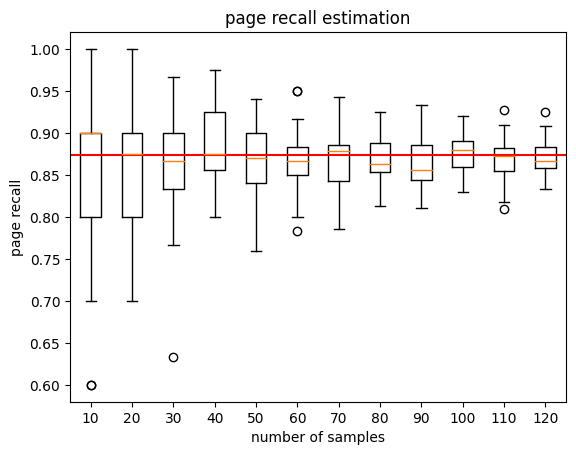

In [186]:
labels, data = [*zip(*res_recalls.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable    
labels, data = res_recalls.keys(), res_recalls.values()

plt.boxplot(data)
plt.axhline(y = .8734, color = 'r', linestyle = '-')
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel('number of samples')
plt.ylabel('page recall')
plt.title('page recall estimation')
plt.show()

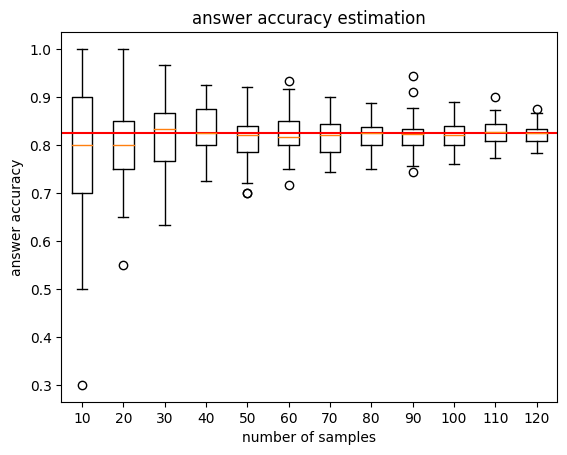

In [187]:
labels, data = [*zip(*res_accs.items())]  # 'transpose' items to parallel key, value lists

# or backwards compatable    
labels, data = res_accs.keys(), res_accs.values()

plt.boxplot(data)
plt.axhline(y = .8241, color = 'r', linestyle = '-')
plt.xticks(range(1, len(labels) + 1), labels)
plt.xlabel('number of samples')
plt.ylabel('answer accuracy')
plt.title('answer accuracy estimation')
plt.show()

Text(0, 0.5, 'page recall')

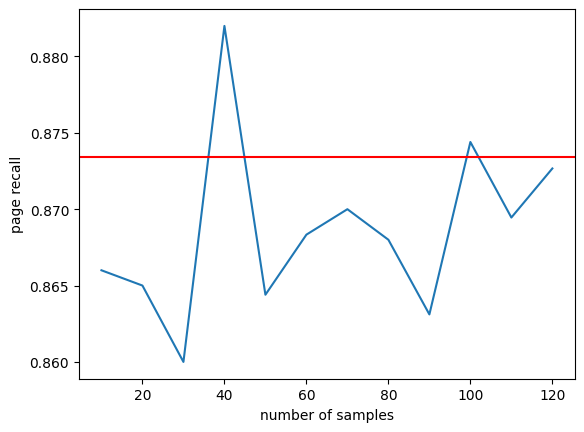

In [188]:
import matplotlib.pyplot as plt
plt.plot(n_all, recalls)
plt.axhline(y = .8734, color = 'r', linestyle = '-')
plt.xlabel('number of samples')
plt.ylabel('page recall')
#plt.ylim(0.5, 1)

Text(0, 0.5, 'answer accuracy')

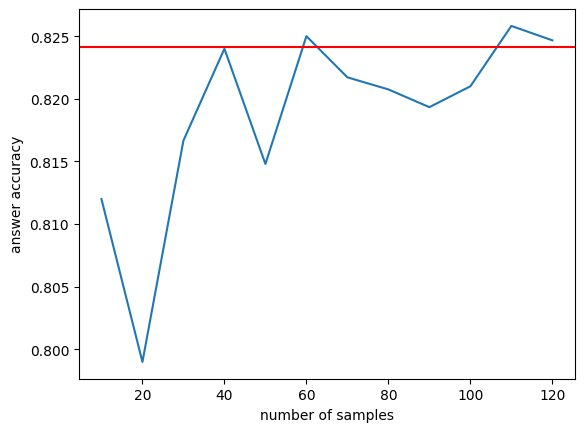

In [189]:
import matplotlib.pyplot as plt
plt.plot(n_all, accs)
plt.axhline(y = .8241, color = 'r', linestyle = '-')
plt.xlabel('number of samples')
plt.ylabel('answer accuracy')
#plt.ylim(0.5, 1)